<a href="https://colab.research.google.com/github/duongnghiephuy/Practice-Simple-Deep-learning/blob/master/weather_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')
fname="/content/gdrive/My Drive/Practice/data/weather.csv"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


If the model is trained on Google Colab:

- The data should be stored in Google Drive. This code then is used to mount Drive so that directory of Drive can be accessed directly by path. 



The data is weather time series dataset provided on Max-Planck_Insitute website.
It records the weather in WS Beutenberg from 01.07.2019 up to 17.10/2019. 

One measurement is taken every 10 minutes.

**The model will learn to predict weather in the future given data in the past.**
In our model, the target output is only predicted temperature.

***The recurrent neural network is especially powerful tool to analyze timeseries data so we will make use of it.***

In [5]:
f=open(fname,"r")
data=f.read()
data=data.split("\n")
header=data[0]
data=data[1:-1]
print("The header of the csv file is\n:",header)
print("The length of data is",len(data))
print("The first data point is:\n",data[0])
print("The data after 10 minutes is:\n",data[1])




  

The header of the csv file is
: ﻿"Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)","rain (mm)","raining (s)","SWDR (W/m²)","PAR (µmol/m²/s)","max. PAR (µmol/m²/s)","Tlog (degC)","CO2 (ppm)"
The length of data is 26064
The first data point is:
 01.01.2019 00:10:00, 1003.45,    6.94,  279.82,    5.54,   90.80,    9.98,    9.07,    0.92,    5.64,    9.04, 1243.74,    1.92,    2.60,  243.90,    0.00,    0.00,    0.00,    0.00,    0.00,   18.45,  421.60
The data after 10 minutes is:
 01.01.2019 00:20:00, 1003.23,    6.94,  279.84,    5.50,   90.50,    9.99,    9.04,    0.95,    5.62,    9.01, 1243.47,    1.60,    2.72,  237.10,    0.00,    0.00,    0.00,    0.00,    0.00,   18.40,  420.60




Values of different attributes have varying scales, which hinders the learning process. That's because we will use MAE(Mean Absolute Error) as the loss function which measures the distance between predicted value and true value.

If one attribute has large scale, its values will be mostly reposible for the loss. That's not what we want in the first stage of learning where attributes are given equal roles.

We normalize data using mean and standard deviation.

In [0]:
import numpy as np
inputs=np.zeros((len(data),21))

i=0
for e in data:
  value=[float(x) for x in e.split(",")[1:]]
  inputs[i,:]=value
  i+=1
mean=np.mean(inputs,axis=0)
std=np.std(inputs,axis=0)
inputs-=mean
inputs/=std


A generator is used to generate 3D float tensor of data before feeding to the neural network. The Date Time column is discarded. 

past: how far in the past that model can look backward (in minutes)

steps: the interval between two peeks into the past of model. This value should not be too small as close data points are usually similar.

future: how far in the future that model predicts

min_index, max_index: the indices used to seperate data into training set, validation set and test set.

batch_size: batch size that generator produces


In [0]:
def generator(data,past,steps,future,min_index,max_index,batch_size):
  i=min_index
  while True:
    if i+batch_size>=max_index:
        i=min_index
    points=np.arange(i,i+batch_size)
    i=i+batch_size
   
    sample=np.zeros((len(points),past//steps,data.shape[-1]))
    target=np.zeros(len(points),)
    for j in range(len(points)):
      indices=range(points[j],points[j]+past,steps)
      sample[j]=data[indices]
      target[j]=data[points[j]+past+future][1]
    yield sample,target
past=1000
steps=5
future=120
batch_size=128

train_gen=generator(inputs,past,steps,future,0,len(data)//2,batch_size)
val_gen=generator(inputs,past,steps,future,len(data)//2,3*len(data)//4,batch_size)
test_gen=generator(inputs,past,steps,future,3*len(data)//4,len(data),batch_size)
      
    
  

Before jumping to the expensive and intense computing reccurent network, we simply set up a feedforward network that is composed of Flatten and Dense Layers.

The Flatten layer is necessary to transform 3D tensor to 2D tensor that Dense Layers can digest.

The output unit simply outputs a 1D tensor consisting of predicted temperature values in the future for each data point. An activation function in this unit will be detrimental to the predicted values.

To improve the model, we tweak:
- Capacity of each Dense Layer to capture enough representative patterns
- **Learning rate** of the optimization function.

The **learning rate** is especially important here. If we use the default value, the model will learn with a high rate, continously skipping the local minimum and resulting in underfitiing. 

In experiment, it causes an awful model.
That's why we delibrately choose it to be small 0.0001.


In [0]:
from keras import models, layers,optimizers

network=models.Sequential()
network.add(layers.Flatten(input_shape=(past//steps,inputs.shape[-1])))
network.add(layers.Dense(64,activation="relu"))
network.add(layers.Dense(64,activation="relu"))
network.add(layers.Dense(1,))

network.compile(loss="mae",optimizer=optimizers.RMSprop(lr=0.0001))
history=network.fit_generator(train_gen,steps_per_epoch=216,epochs=20,validation_data=val_gen,validation_steps=128)




Epoch 1/20
216/216 [==============================] - 6s 27ms/step - loss: 0.3755 - val_loss: 0.7819
Epoch 2/20
216/216 [==============================] - 5s 25ms/step - loss: 0.2665 - val_loss: 0.7998
Epoch 3/20
216/216 [==============================] - 5s 25ms/step - loss: 0.2289 - val_loss: 0.7763
Epoch 4/20
216/216 [==============================] - 5s 25ms/step - loss: 0.2068 - val_loss: 0.7834
Epoch 5/20
216/216 [==============================] - 6s 26ms/step - loss: 0.1911 - val_loss: 0.7902
Epoch 6/20
216/216 [==============================] - 6s 26ms/step - loss: 0.1846 - val_loss: 0.8044
Epoch 7/20
216/216 [==============================] - 5s 25ms/step - loss: 0.1775 - val_loss: 0.8079
Epoch 8/20
216/216 [==============================] - 5s 24ms/step - loss: 0.1582 - val_loss: 0.7889
Epoch 9/20
216/216 [==============================] - 5s 24ms/step - loss: 0.1503 - val_loss: 0.7503
Epoch 10/20
216/216 [==============================] - 5s 25ms/step - loss: 0.1475 - val_lo

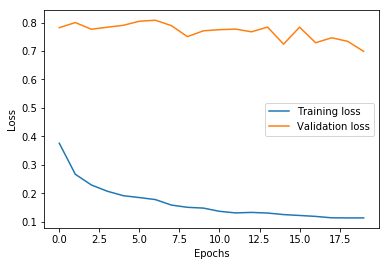

In [0]:
training_loss=history.history["loss"]
validation_loss=history.history["val_loss"]
import matplotlib.pyplot as plt
plt.plot(range(len(training_loss)),training_loss,label="Training loss")
plt.plot(range(len(training_loss)),validation_loss,label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

The model overfits from the first epochs but the loss indicates a relatively good model with low computing price.

The loss in validation set is around 0.8.

***Recurrent network: ***
Simply  speaking, the recurrent network ultilizes the time nature of the data. As with weather, the closer the data point, the more representative power it has.

Simple recurrent network uses only one function and optimizes it by running it over time( time axis in data) 

Model strucuture:
- GRU Layer
- Dense Layer 

Learning rate is set at 0.0001 to prevent underfitting.

In [0]:
from keras import models, layers,optimizers

network=models.Sequential()
network.add(layers.GRU(64,input_shape=(None,inputs.shape[-1]),activation="tanh"))
network.add(layers.Dense(1,))

network.compile(loss="mae",optimizer=optimizers.RMSprop(lr=0.0001))
history=network.fit_generator(train_gen,steps_per_epoch=216,epochs=20,validation_data=val_gen,validation_steps=128)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
216/216 [==============================] - 51s 238ms/step - loss: 0.3572 - val_loss: 0.3855
Epoch 2/20
216/216 [==============================] - 50s 230ms/step - loss: 0.3227 - val_loss: 0.3383
Epoch 3/20
216/216 [==============================] - 50s 232ms/step - loss: 0.3152 - val_loss: 0.3408
Epoch 4/20
216/216 [==============================] - 50s 230ms/step - loss: 0.3076 - val_loss: 0.3333
Epoch 5/20
216/216 [==============================] - 50s 231ms/step - loss: 0.2977 - val_loss: 0.3439
Epoch 6/20
216/216 [==============================] - 50s 229ms/step - loss: 0.2987 - val_loss: 0.3386
Epoch 7/20
216/216 [==============================] - 49s 229ms/step - loss: 0.2941 - val_loss: 0.3323
Epoch 8/20
216/216 [==============================] - 49s 228ms/step - loss: 0.2840 - val_loss: 0.3358
Epoch 9/20
216/216 [==============================] - 50s 230ms/step - loss: 0.278

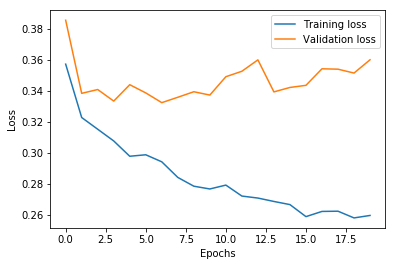

In [0]:
training_loss=history.history["loss"]
validation_loss=history.history["val_loss"]
import matplotlib.pyplot as plt
plt.plot(range(len(training_loss)),training_loss,label="Training loss")
plt.plot(range(len(training_loss)),validation_loss,label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Even though the overal loss is not rewarding compared to a cheap feedforward network, this model is more stable.

The loss in validation set is significantly lower only hovering around 0.34

We try to add more GRU Layers.

In [0]:
from keras import models, layers,optimizers

network=models.Sequential()
network.add(layers.GRU(64,input_shape=(None,inputs.shape[-1]),activation="tanh",dropout=0.1,recurrent_dropout=0.2,return_sequences=True))
network.add(layers.GRU(64,activation="tanh",dropout=0.1,recurrent_dropout=0.2))
network.add(layers.Dense(1,))

network.compile(loss="mae",optimizer=optimizers.RMSprop(lr=0.0001))
history=network.fit_generator(train_gen,steps_per_epoch=216,epochs=25,validation_data=val_gen,validation_steps=128)

Epoch 1/25
216/216 [==============================] - 138s 638ms/step - loss: 0.4372 - val_loss: 0.3260
Epoch 2/25
216/216 [==============================] - 140s 648ms/step - loss: 0.3460 - val_loss: 0.3302
Epoch 3/25
216/216 [==============================] - 136s 631ms/step - loss: 0.3317 - val_loss: 0.3273
Epoch 4/25
216/216 [==============================] - 137s 635ms/step - loss: 0.3266 - val_loss: 0.3404
Epoch 5/25
216/216 [==============================] - 139s 642ms/step - loss: 0.3264 - val_loss: 0.3498
Epoch 6/25
216/216 [==============================] - 137s 635ms/step - loss: 0.3147 - val_loss: 0.3383
Epoch 7/25
216/216 [==============================] - 139s 644ms/step - loss: 0.3139 - val_loss: 0.3553
Epoch 8/25
216/216 [==============================] - 137s 635ms/step - loss: 0.3129 - val_loss: 0.3444
Epoch 9/25
216/216 [==============================] - 140s 649ms/step - loss: 0.3156 - val_loss: 0.3301
Epoch 10/25
216/216 [==============================] - 136s 628m

In [0]:
import matplotlib.pyplot as plt
def drawgraph(history):
  training_loss=history.history["loss"]
  validation_loss=history.history["val_loss"]
  plt.plot(range(len(training_loss)),training_loss,label="Training loss")
  plt.plot(range(len(training_loss)),validation_loss,label="Validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()


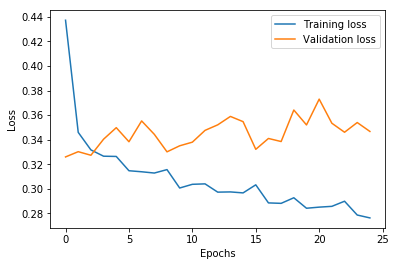

In [0]:
drawgraph(history)

The overall result is not higher than the previous model. It means we should resort to other methods to improve model or stop with the previous one.